/Users/drew/anaconda3/envs/ts-exp/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(<matplotlib.axes._subplots.AxesSubplot at 0x1135472b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115989e10>)

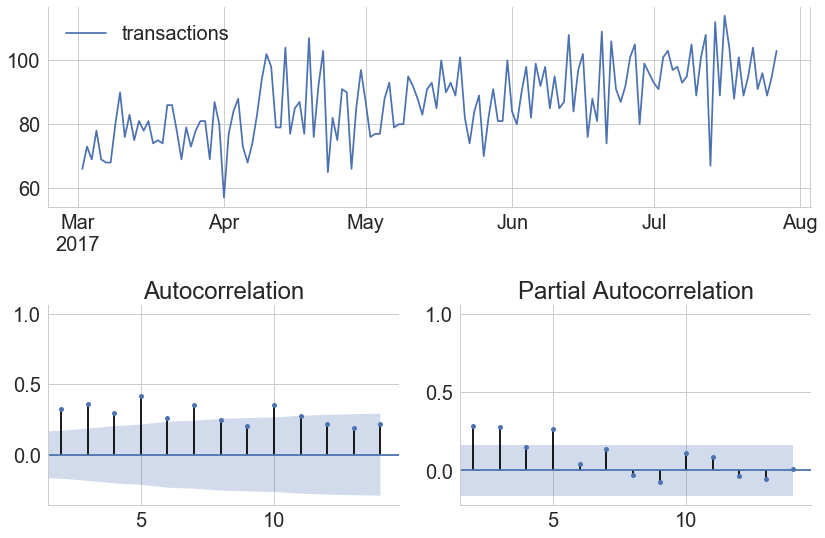

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
from scipy.stats import boxcox, kstest, mstats
from scipy.special import inv_boxcox
from utils import poisson_process, plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [12, 8]})

df = poisson_process.nhpp(
    λ=100, n=15000, t0='2017-03-01', freq='1D', 
    thinning_components=[{'function': poisson_process._trend, 
                          'params': {'percent_increase': 1.0, 'period': 365}}]).to_frame()

plotting.tsplot(df, lags=14)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           transactions   No. Observations:                  122
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -440.650
Date:                Mon, 18 Dec 2017   AIC                            887.300
Time:                        12:05:15   BIC                            895.712
Sample:                    03-02-2017   HQIC                           890.717
                         - 07-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1577      0.023      6.872      0.000       0.113       0.203
ma.L1         -0.9999      8.003     -0.125      0.901     -16.686      14.686
sigma2        81.9406    654.316      0.125      0.900   -1200.496    1364.377
===================================================================================
Ljung-Box (Q):                       38.69   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.53   Prob(JB):                         0.94
Heteroskedasticity (H):               1.26   Skew:                             0.08
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

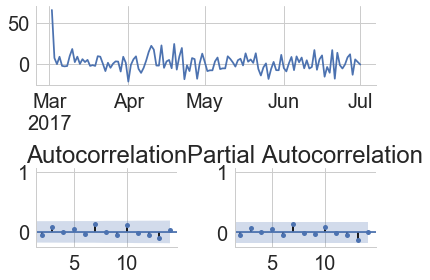

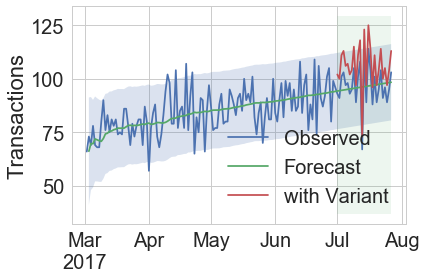

In [2]:
treatment_start = '2017-07-01'
effect_size = 0.10
df.loc[treatment_start:, 'response'] = effect_size
df['transactions_with_response'] = (df['transactions'] * (1 + df['response'].fillna(0))).astype(int)

mod = smt.SARIMAX(df.loc[:treatment_start, 'transactions'], 
                  order=(0, 1, 1), 
                  seasonal_order=(0, 0, 0, 0),
                  trend='c')
res = mod.fit()

pred = res.get_prediction(start='2017-03-03', end=max(df.index), dynamic=treatment_start)
df['prediction'] = pred.predicted_mean
df[['prediction_lower', 'prediction_upper']] = pred.conf_int()

plotting.tsplot(res.resid, lags=14)

fig = plt.figure()
ax = df['transactions'].plot(label='Observed')
df['prediction'].plot(ax=ax, label='Forecast')
ax.fill_between(df.index, df['prediction_lower'], df['prediction_upper'], alpha=0.2)
df.loc[treatment_start:, 'transactions_with_response'].plot(ax=ax, label='with Variant')
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp(treatment_start), df.index[-1], alpha=0.1)
ax.set_ylabel('Transactions')
ax.legend()

res.summary()

In [ ]:
import datetime
import pandas as pd
import pymc3 as pm
from theano import scan, shared
import theano.tensor as tt

def sarima_interrupted(X, interruption, 
                       (p, d, q)=(None, None, None), 
                       (P, D, Q, s)=(None, None, None, None),
                       trend=False):
    """
    Seasonal ARIMA time series model to estimate interruption effect size ω

    Parameters
    ----------
    X : pd.Series
        The time series to be fit, with index of type pd.DatetimeIndex 
    interruption : pd.Timestamp, datetime.datetime/date, or str
        Effect size ω applies to all X for which index >= interruption
    (p, d, q) : (int, int, int), optional
        ARIMA order, AR(p) I(d) MA(q)
    (P, D, Q, s) : (int, int, int, int), optional
        Seasonal ARIMA order, AR(P) I(D) MA(Q) with period s timesteps
    trend : bool, optional
        Whether to add a constant term δ to the model given drift δ/(1 − Σφi)

    Returns
    -------
    PyMC3 model with traces for each required parameter in the model.
    σ : root-variance of the white noise terms ε of the model
    ω : effect size for which X_t = Y_t * (1 + ω) for all t >= interruption
         Note: X_t are the raw observations, whereas Y_t is what the time 
               series would be would with no interruption, where a single 
               ARIMA model would be fit across the interruption boundary
    δ : intercept of the ARIMA model, giving rise to drift δ/(1 − Σφi)
    φ_1, φ_2, ..., φ_p : p parameters describing the autoregressive model
    θ_1, θ_2, ..., θ_q : q parameters describing the moving average model
    Φ_1, Φ_2, ..., Φ_P : P parameters describing the autoregressive model 
                           with seasonal period s
    Θ_1, Θ_2, ..., Θ_Q : Q parameters describing the moving average model 
                           with seasonal period s
    """
    

In [262]:
import theano
theano.config.compute_test_value = 'ignore'

order = 1
period = 2
a = (1, 7, 2, 3, 5, 8, 13)

X = theano.tensor.vector('X') 
f = theano.function([X], (X - tt.roll(X, period))[period:])
f(a)

array([ 1., -4.,  3.,  5.,  8.])

In [263]:
import theano
import theano.tensor as tt

#     for _ in range(order):
#         X = X.diff(period)
#     return X

order = tt.iscalar('order')
period = tt.iscalar('period')
X = tt.vector('X')

result, updates = theano.scan(fn=lambda y: (y - tt.roll(y, period))[period:],
                              outputs_info=X,
                              n_steps=order)

nabla = theano.function(inputs=[X, order, period], outputs=final_result)

nabla((1, 7, 2, 3, 5, 8, 13), 1, 2)

ValueError: could not broadcast input array from shape (5) into shape (7)
Apply node that caused the error: forall_inplace,cpu,scan_fn}(Elemwise{Maximum}[(0, 0)].0, IncSubtensor{InplaceSet;:int64:}.0, period, ScalarFromTensor.0)
Toposort index: 15
Inputs types: [TensorType(int64, scalar), TensorType(float64, matrix), TensorType(int32, scalar), Scalar(int32)]
Inputs shapes: [(), (2, 7), (), ()]
Inputs strides: [(), (56, 8), (), ()]
Inputs values: [array(1), 'not shown', array(2, dtype=int32), 2]
Outputs clients: [[Subtensor{int64}(forall_inplace,cpu,scan_fn}.0, ScalarFromTensor.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [259]:
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

TypeError: clip() missing 1 required positional argument: 'a_max'

In [233]:
order = 1
period = 2

X = pd.Series([1, 7, 2, 3, 5, 8, 13])
for _ in range(order):
    print(len(X))
    X = np.diff(X, period)
print(len(X))
X

7
5


array([-11,   6,   1,   1,   2])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:32<00:00, 76.94it/s]


[-0.08851125579746635, 0.120677286541376, 0.4029976658529103]


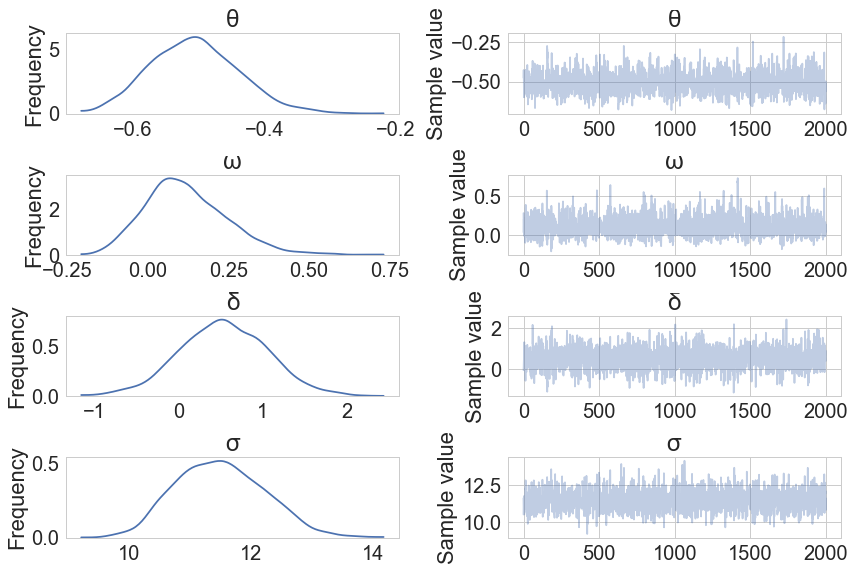

In [4]:
import pymc3 as pm
from theano import scan, shared
import theano.tensor as tt

def build_model(X, treatment_start, treatment_observations):
    time_seen = pd.to_datetime(treatment_start) + pd.DateOffset(treatment_observations - 1)
    y = shared(X[:time_seen].values)
    y_switch = shared(X[:time_seen].index < treatment_start)
    with pm.Model() as i1ma1:
        σ = pm.HalfCauchy('σ', beta=10.)
        θ = pm.Normal('θ', 0., sd=1.)
        ω = pm.Normal('ω', 0., sd=5.)
        δ = pm.Normal('δ', 0., sd=5.)

        # ARIMA (0, 1, 1)
        # ---------------
        # (1 - φB) * y[t] = (1 - θB) * ε[t]
        # y[t] - φ * y[t-1] = ε[t] - θ * ε[t-1]
        # ε[t] = (y[t] - μ) - (φ * (y[t-1] - μ) + θ * ε[t-1])
        # ε[t] = y[t] - (φ * y[t-1] + θ * ε[t-1]) - μ * (1 + φ)
        # 
        # (1 - B) (y[t] - μ) = (1 + θB) ε[t]
        # y[t] - y[t-1] = ε[t] + θ * ε[t-1]
        # ε[t] = y[t] - y[t-1] - θ * ε[t-1]
        y_adj = tt.switch(y_switch, y, tt.dot(y, tt.inv(1 + ω)))
        ε0 = y_adj[0] - 2 * δ
        ε, _ = scan(fn=lambda y_lag1, y_lag0, ε_prior, θ, δ: y_lag0 - y_lag1 - θ * ε_prior - δ,
                    sequences=dict(input=y_adj, taps=[-1, 0]),
                    outputs_info=[ε0],
                    non_sequences=[θ, δ])

        pm.Potential('like', pm.Normal.dist(0, sd=σ).logp(ε))
    return i1ma1

treatment_observations = 4
with build_model(df['transactions_with_response'], 
                 treatment_start, 
                 treatment_observations):
    trace = pm.sample(2000)

pm.traceplot(trace, combined=True)
print('[{lower}, {expectation}, {upper}]'.format(
    expectation=trace['ω'].mean(),
    lower=np.percentile(trace['ω'], (1 - 0.95) / 2 * 100),
    upper=np.percentile(trace['ω'], (1 - (1 - 0.95) / 2) * 100)))

In [11]:
isinstance(build_model(df['transactions_with_response'], treatment_start, treatment_observations),
           pm.Model)

True

In [255]:
(df[treatment_start:][:16]['transactions'] / df[treatment_start:][:16]['prediction'] - 1).rolling(16, min_periods=1).mean()

2017-07-01   -0.055968
2017-07-02   -0.045939
2017-07-03    0.021121
2017-07-04    0.000828
2017-07-05   -0.035084
2017-07-06   -0.055671
2017-07-07   -0.043201
2017-07-08   -0.024741
2017-07-09   -0.023521
2017-07-10    0.013320
2017-07-11    0.000989
2017-07-12    0.005569
2017-07-13    0.007706
2017-07-14    0.027484
2017-07-15    0.027679
2017-07-16    0.019885
Freq: D, dtype: float64


1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:17<00:00, 56.41it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:15<00:00, 66.05it/s]



4


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:17<00:00, 58.65it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:14<00:00, 68.10it/s]



16


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:17<00:00, 57.26it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:17<00:00, 56.16it/s]


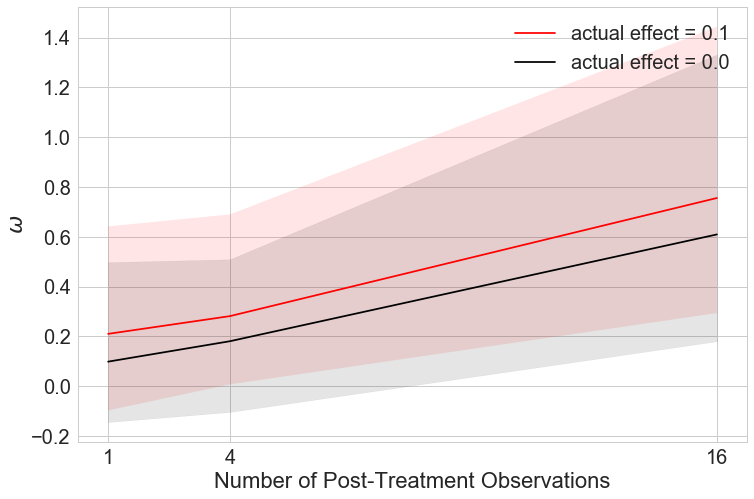

In [263]:
ω = []
ω_lower = []
ω_upper = []

n = []
n_lower = []
n_upper = []

obs = [1, 4, 16]

for treatment_observations in obs:
    print()
    print(treatment_observations)
    with build_model(df['transactions_with_response'], 
                     treatment_start, 
                     treatment_observations):
        trace = pm.sample(500)
    ω.append(trace['ω'].mean())
    ω_lower.append(np.percentile(trace['ω'], (1 - 0.95) / 2 * 100))
    ω_upper.append(np.percentile(trace['ω'], (1 - (1 - 0.95) / 2) * 100))
    
    with build_model(df['transactions'], 
                     treatment_start, 
                     treatment_observations):
        trace = pm.sample(500)
    n.append(trace['ω'].mean())
    n_lower.append(np.percentile(trace['ω'], (1 - 0.95) / 2 * 100))
    n_upper.append(np.percentile(trace['ω'], (1 - (1 - 0.95) / 2) * 100))
    
fig, ax = plt.subplots(1, 1)
ax.plot(obs, ω, label='actual effect = 0.1', color='red')
ax.fill_between(obs, ω_lower, ω_upper, alpha=.1, facecolor='red')
ax.plot(obs, n, label='actual effect = 0.0', color='black')
ax.fill_between(obs, n_lower, n_upper, alpha=.1, color='black')
ax.set_xticks(obs)
ax.set_xlabel('Number of Post-Treatment Observations')
ax.set_ylabel('$\omega$')
ax.legend()